In [1]:
# from src.common.logger import get_logger

# logger = get_logger(__name__)

In [2]:
import json
import os
from typing import Dict

import pandas as pd
import tensorflow as tf
import yaml

from src.common.load_data import load_featurized_data

from src.config.const import (
    HISTORY_PATH,
    JOB_ROOT_FOLDER,
    TARGET_DF_PATH,
    VALUATION_PATH,
)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from datetime import datetime as dtime
import numpy as np
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)

2022-11-19 20:28:31.124291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 20:28:31.293825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-19 20:28:31.293844: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-19 20:28:31.326293: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-19 20:28:31.934603: W tensorflow/stream_executor/platform/de

In [3]:
def predict_load(model, pred_dataset: pd.DataFrame, params: Dict):
    """If the param MODEL_TYPE is set to "AUTOREGRESSIVE" in params.yaml,
        return autoregressive predictions.

    Args:
        model (_type_): _description_
        pred_dataset (_type_): _description_
        params (_type_): _description_

    Returns:
        _type_: _description_
    """
    autoreg_steps = params["featurize"]["TARGET_PERIOD"]
    model_type = params["featurize"]["MODEL_TYPE"]
    temp_pred_dataset = pred_dataset.copy()

    if model_type == "AUTOREGRESSIVE":
        for autoreg_step in range(1, autoreg_steps + 1):
            next_prediction = model.predict(
                temp_pred_dataset.iloc[:, -autoreg_steps:], verbose=0
            )
            temp_pred_dataset[f"previsão semana {autoreg_step}"] = next_prediction

        temp_pred_dataset.index = pred_dataset.index

    elif model_type == "SINGLE-SHOT":
        temp_pred = model.predict(temp_pred_dataset, verbose=0)
        temp_pred_dataset = temp_pred_dataset.merge(
            pd.DataFrame(
                temp_pred,
                index=pred_dataset.index,
                columns=[
                    f"previsão semana {week}" for week in range(1, autoreg_steps + 1)
                ],
            ),
            on="din_instante",
            how="outer",
        )

    return temp_pred_dataset

In [4]:
with open(HISTORY_PATH, "r") as history_file:
        history = json.load(history_file)

load_dataset_list = load_featurized_data()

params = yaml.safe_load(open("params.yaml"))
window_size = params["featurize"]["WINDOW_SIZE"]
model = tf.keras.models.load_model(
    JOB_ROOT_FOLDER / "src" / "model" / "model_train.h5"
)

# make prediction
train_pred = predict_load(model, load_dataset_list["train_pred"][0], params=params)
train_pred_date = train_pred.index + pd.Timedelta(days=7 * window_size)
train_pred["Data Previsão"] = [str(date).split(" ")[0] for date in train_pred_date]

val_pred = predict_load(model, load_dataset_list["val"][0], params=params)
val_pred_date = val_pred.index + pd.Timedelta(days=7 * window_size)
val_pred["Data Previsão"] = [str(date).split(" ")[0] for date in val_pred_date]
#    test_pred = predict_load(model, load_dataset_list["test"][0], params=params)
pred_list = [
    train_pred,
    val_pred,
    #    test_pred
]

df_target = pd.read_csv(TARGET_DF_PATH, index_col="Data")
os.makedirs(VALUATION_PATH, exist_ok=True)

2022-11-19 20:28:33.456943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-19 20:28:33.456965: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-19 20:28:33.456983: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pd-84M6Q53): /proc/driver/nvidia/version does not exist
2022-11-19 20:28:33.457234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


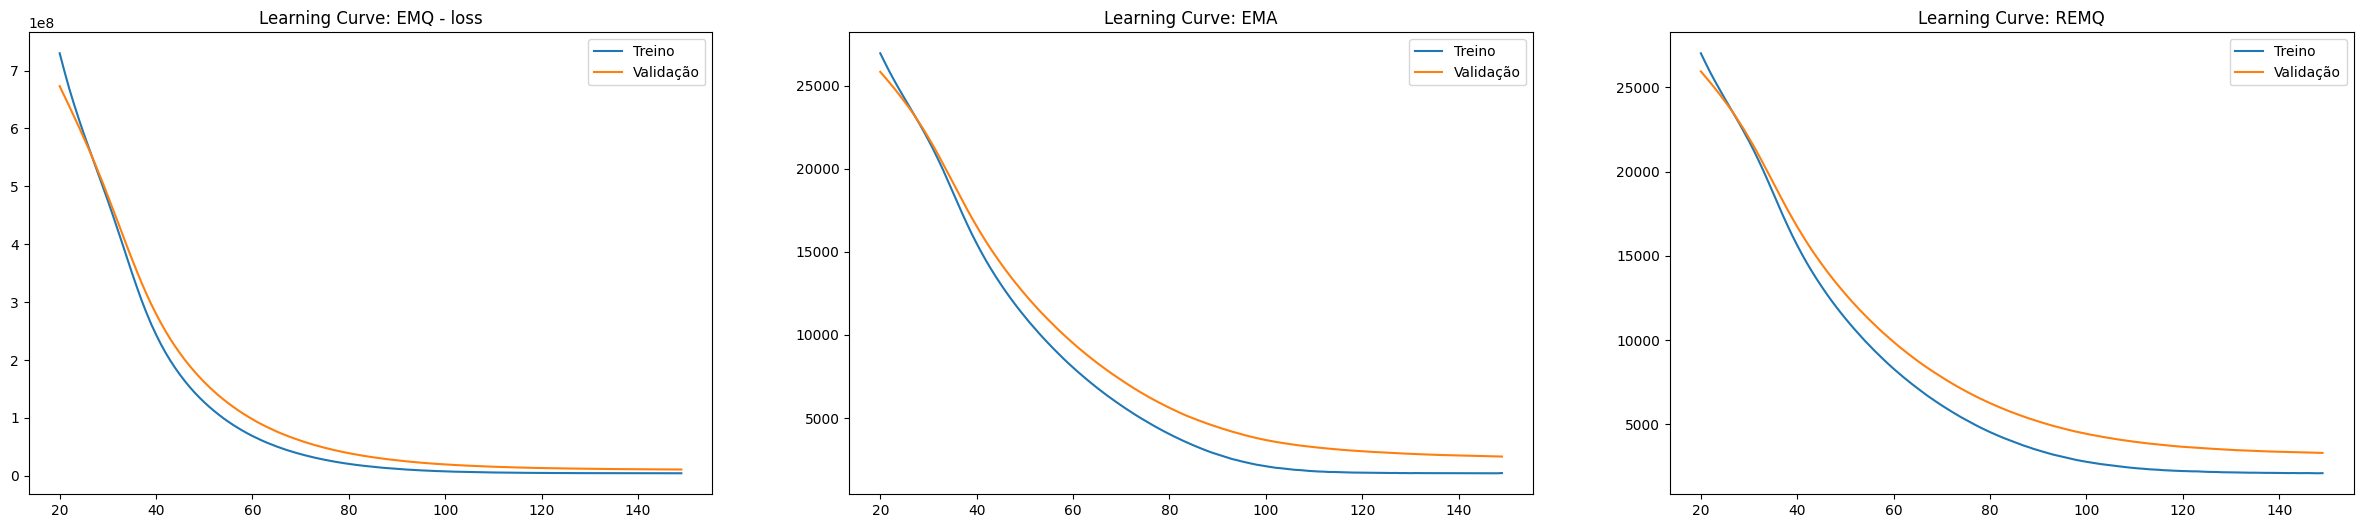

In [5]:
def learning_curves(history, skip, plot=False):

    fig, ax = plt.subplots(figsize=(30, 6), nrows=1, ncols=3)
    metrics_list = [
        "loss",
        "val_loss",
        "mean_absolute_error",
        "val_mean_absolute_error",
        "root_mean_squared_error",
        "val_root_mean_squared_error",
    ]

    name_dict = {0: "Treino", 1: "Validação"}

    for i, metric in enumerate(metrics_list):
        # plot train and validation metrics on the same plot
        if i <= 1:
            ax1 = ax.ravel()[0]
        elif i > 1 and i <= 3:
            ax1 = ax.ravel()[1]
        else:
            ax1 = ax.ravel()[2]

        if (i % 2) == 0:
            curve_label = "Treino"
        else:
            curve_label = "Validação"

        sns.lineplot(
            x=range(skip, len(history[metric])),
            y=history[metric][skip:],
            ax=ax1,
            label=curve_label,
        )

    ax.ravel()[0].set_title("Learning Curve: EMQ - loss")
    ax.ravel()[1].set_title("Learning Curve: EMA")
    ax.ravel()[2].set_title("Learning Curve: REMQ")

    if plot:
        plt.show()

    return fig



lc_fig = learning_curves(history=history, skip=20)
lc_fig.savefig(VALUATION_PATH / "learning_curves.png")


[2022-11-19 20:28:36] INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=731661;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=285426;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=361184;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=108900;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

[2022-11-19 20:28:37] INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=955067;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=995706;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=678413;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=241608;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=615370;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=537265;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=239510;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=372392;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=883842;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=672242;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=288837;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=724818;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=832078;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=682248;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=314870;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=500774;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=820549;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=519235;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=6955;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=434403;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

[2022-11-19 20:28:38] INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=176293;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=2736;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=74169;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=712533;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=682443;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=187832;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=280658;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=439285;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=557477;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=707893;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=82163;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=936265;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=827812;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=290475;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=930371;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=659319;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

[2022-11-19 20:28:39] INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=286501;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=258170;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=637925;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=636363;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=690951;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=608560;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=178422;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=389414;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=681470;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=363784;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=276163;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=612874;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=334500;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=347520;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

[2022-11-19 20:28:40] INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=585301;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=126624;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=730685;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=297490;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=601510;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=290286;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

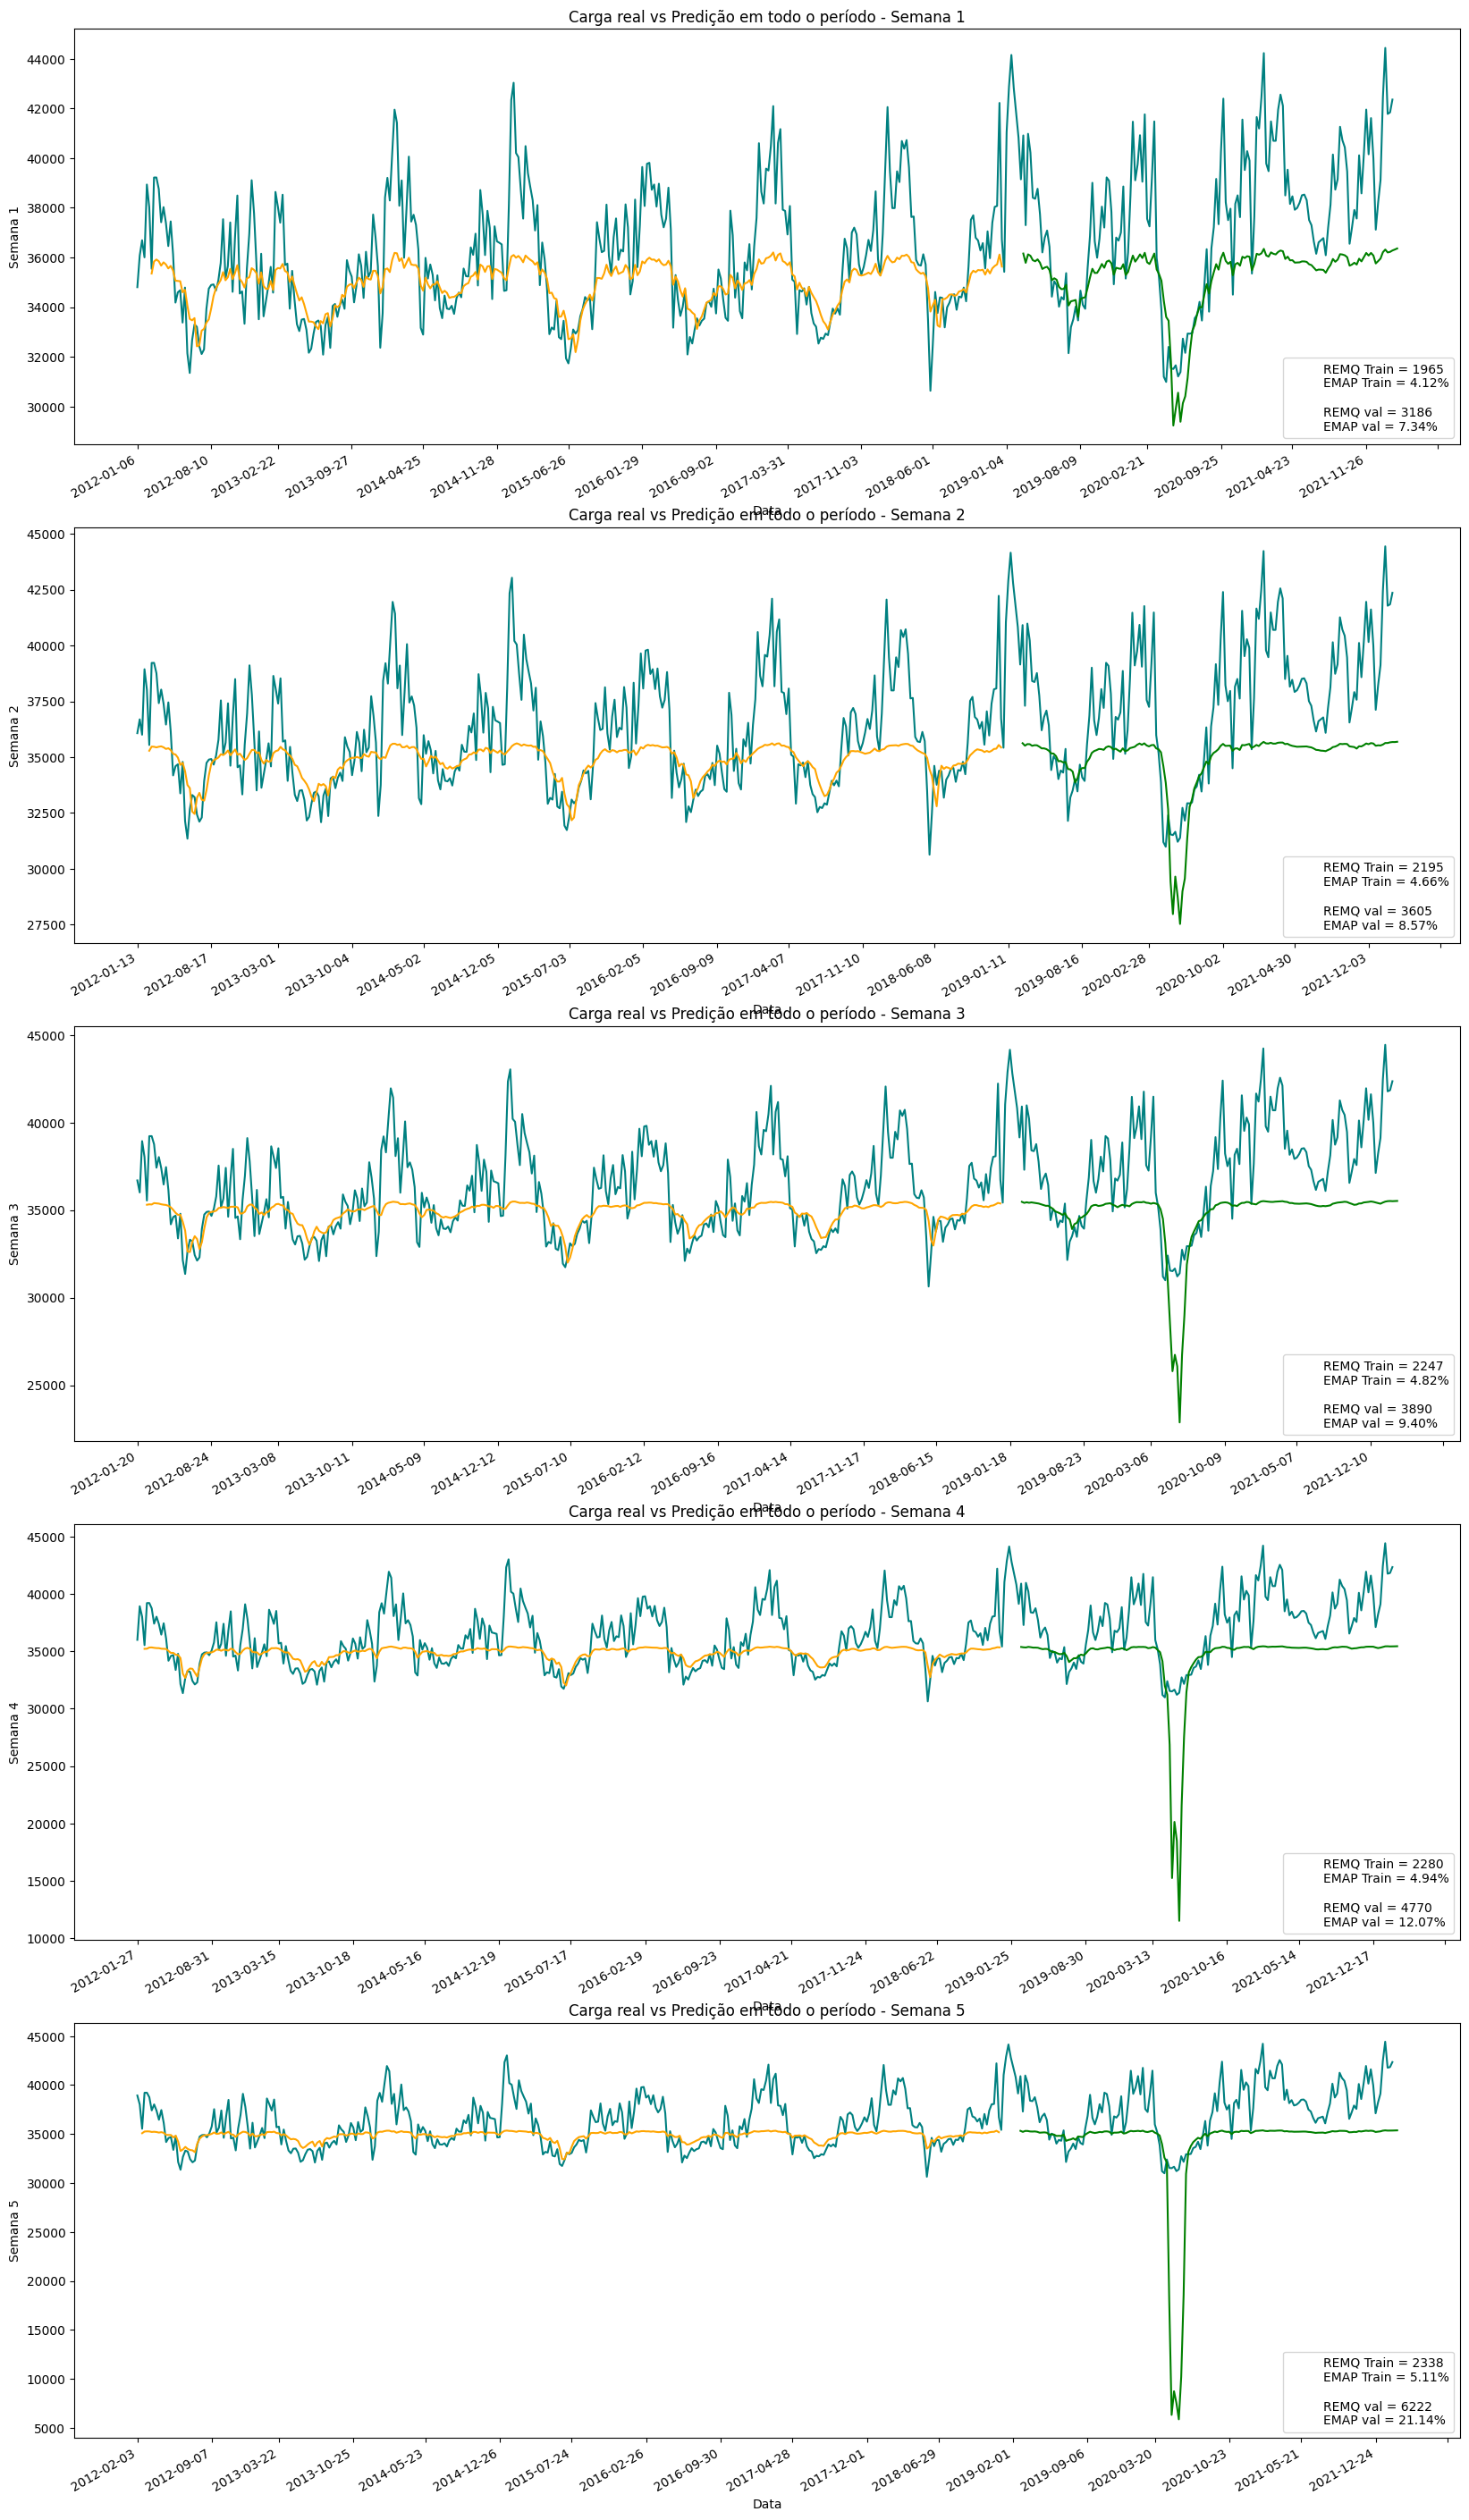

In [6]:
def plot_predicted_series(pred_list, df_target, plot=False):

    params = yaml.safe_load(open("params.yaml"))

    window_size = params["featurize"]["WINDOW_SIZE"]
    # window size in days
    if params["featurize"]["HOW_INPUT_WINDOW_GEN"] == "daily":
        window_size = window_size / 7

    colors = ["orange", "green"]
    dataset_names = ["Treino", "Validação"]
    fig, ax = plt.subplots(figsize=(20, 35), ncols=1, nrows=5)

    # loop over 5 weeks
    for week_count in range(0, params["featurize"]["TARGET_PERIOD"]):

        extra = plt.Rectangle(
            (0, 0), 0, 0, fc="none", fill=False, ec="none", linewidth=0
        )

        # plot measured data
        sns.lineplot(
            x=df_target.iloc[week_count:].index,
            y=df_target[f"Semana {week_count+1}"].iloc[: -week_count or None],
            ax=np.ravel(ax)[week_count],
            color="teal",
            label="Carga Real",
        )

        # plot predicted data
        for pred_set, color, ds_name in zip(pred_list, colors, dataset_names):

            # shift index so it shows date of prediction
            true_index = pred_set.index.astype("datetime64[ms]") + pd.Timedelta(
                value=7 * (window_size-1), unit="d"
            )  # -1
            x_value = [str(index_unit).split(" ")[0] for index_unit in true_index]
            y_value = pred_set.loc[:, f"previsão semana {week_count+1}"].values

            sns.lineplot(
                x=x_value,
                y=y_value,
                ax=np.ravel(ax)[week_count],
                color=color,
                label=ds_name,
            )

        np.ravel(ax)[week_count].set_title(
            f"Carga real vs Predição em todo o período - Semana {week_count+1}"
        )

        # calculate scores
        score_list_by_dataset = []

        for pred_set in pred_list:
            pred_set_to_avaluate = pred_set.iloc[:-3]
            # generate true date index
            score_list_by_dataset.extend(
                [
                    mean_squared_error(
                        pred_set_to_avaluate.loc[:, f"previsão semana {week_count+1}"],
                        df_target[f"Semana {week_count+1}"].loc[
                            pred_set_to_avaluate["Data Previsão"].values
                        ],
                        squared=False,
                    ),
                    mean_absolute_percentage_error(
                        pred_set_to_avaluate.loc[:, f"previsão semana {week_count+1}"],
                        df_target[f"Semana {week_count+1}"].loc[
                            pred_set_to_avaluate["Data Previsão"].values
                        ],
                    )
                    * 100,
                ]
            )

        scores = (
            r"REMQ Train = {:.0f}"
            + "\n"
            + r"EMAP Train = {:.2f}%"
            + "\n\n"
            + r"REMQ val = {:.0f}"
            + "\n"
            + r"EMAP val = {:.2f}%"
        ).format(*score_list_by_dataset)

        np.ravel(ax)[week_count].legend([extra], [scores], loc="lower right")

        # add rectangle patch
        np.ravel(ax)[week_count].add_patch(extra)
        # patch coordinates
        extra_x, extra_y = extra.get_xy()
        cx = extra_x + extra.get_width() / 2.0
        cy = extra_y + extra.get_height() / 2.0
        np.ravel(ax)[week_count].annotate(
            scores,
            (cx, cy),
            color="black",
            weight="bold",
            fontsize=10,
            ha="center",
            va="center",
        )

        # np.ravel(ax)[week_count].legend(loc='upper left')

        np.ravel(ax)[week_count].xaxis.set_major_locator(mdates.MonthLocator())
        np.ravel(ax)[week_count].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=1))

        for label in np.ravel(ax)[week_count].get_xticklabels(which="major"):
            label.set(rotation=30, horizontalalignment="right")

    if plot:
        plt.show()
    return fig


pred_series_fig = plot_predicted_series(
    pred_list=pred_list,
    df_target=df_target,
)
pred_series_fig.savefig(os.path.join(VALUATION_PATH, "prediction_series.png"))


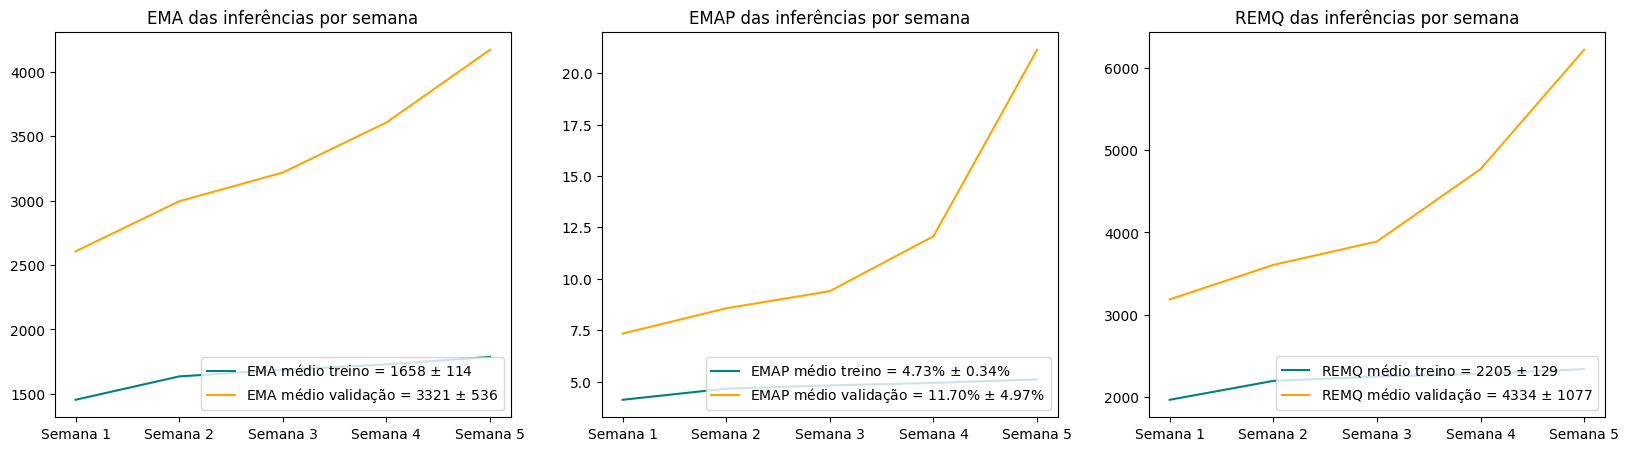

In [7]:
import matplotlib.patches as mpatches

def generate_metrics_semana(df_target, pred_list, plot=False):
    """Generates metrics for prediction performance of the 5 predicted weeks
    and generates plot for such metrics

    Args:
        df_target (_type_): dataframe with target values
        pred_list (_type_): list with predictions for train, val and test dataset as items
        id (_type_): _description_
        save (bool, optional): If True, saves plots as png. Defaults to False.
        plot (bool, optional): If True, show plots. Defaults to False.

    Returns:
        _type_: list with dataframes of
    """
    name_dict = {0: "treino", 1: "validação", 2: "teste"}

    fig, ax = plt.subplots(figsize=(20, 5), ncols=3)

    train_metrics_df = pd.DataFrame(index=[f"Semana {week}" for week in range(1, 6)])
    val_metrics_df = pd.DataFrame(index=[f"Semana {week}" for week in range(1, 6)])
    test_metrics_df = pd.DataFrame(index=[f"Semana {week}" for week in range(1, 6)])
    metrics_df_list = [train_metrics_df, val_metrics_df, test_metrics_df]

    mae_plot_list = [0, 0]
    mape_plot_list = [0, 0]
    rmse_plot_list = [0, 0]

    colors_list = ["teal", "orange"]

    # df_set will take the values: train_pred, val_pred and test_pred
    for i, pred_set in enumerate(pred_list):

        # drop last rows with nan values from autoregressiveness, if it's on
        # 3 samples makes no difference so we drop them anyway
        pred_set_to_avaluate = pred_set.iloc[:-3]

        mae_list = []
        mape_list = []
        rmse_list = []

        # loops the five weeks
        for week in range(0, 5):

            # adds mae of each week to mae_list
            mae_list.append(
                mean_absolute_error(
                    pred_set_to_avaluate.loc[:, f"previsão semana {week+1}"],
                    df_target[f"Semana {week+1}"].loc[
                        pred_set_to_avaluate["Data Previsão"].values
                    ],
                )
            )

            # adds mape of each week to mape_list
            mape_list.append(
                mean_absolute_percentage_error(
                    pred_set_to_avaluate.loc[:, f"previsão semana {week+1}"],
                    df_target[f"Semana {week+1}"].loc[
                        pred_set_to_avaluate["Data Previsão"].values
                    ],
                )
                * 100
            )

            # adds mse of each week to rmse_list
            rmse_list.append(
                mean_squared_error(
                    pred_set_to_avaluate.loc[:, f"previsão semana {week+1}"],
                    df_target[f"Semana {week+1}"].loc[
                        pred_set_to_avaluate["Data Previsão"].values
                    ],
                    squared=False,
                )
            )

        legend_text_mae = (r"EMA médio {} = {:.0f} $\pm$ {:.0f}").format(
            name_dict[i], np.mean(mae_list), np.std(mae_list)
        )
        legend_text_mape = (r"EMAP médio {} = {:.2f}% $\pm$ {:.2f}%").format(
            name_dict[i], np.mean(mape_list), np.std(mape_list)
        )
        legend_text_rmse = (r"REMQ médio {} = {:.0f} $\pm$ {:.0f}").format(
            name_dict[i], np.mean(rmse_list), np.std(rmse_list)
        )

        # plot EMA by week
        mae_plot_list[i] = sns.lineplot(
            x=range(1, 6),
            y=mae_list,
            ax=ax[0],
            color=colors_list[i],
            label=legend_text_mae,
        )
        # plot mape by week
        mape_plot_list[i] = sns.lineplot(
            x=range(1, 6),
            y=mape_list,
            ax=ax[1],
            color=colors_list[i],
            label=legend_text_mape,
        )
        # plot EMQ by week
        rmse_plot_list[i] = sns.lineplot(
            x=range(1, 6),
            y=rmse_list,
            ax=ax[2],
            color=colors_list[i],
            label=legend_text_rmse,
        )

        # saves weekly metrics to a df
        metrics_df_list[i]["EMA"] = mae_list
        metrics_df_list[i]["EMAP"] = mape_list
        metrics_df_list[i]["REMQ"] = rmse_list

    ax[0].set_title("EMA das inferências por semana")
    ax[0].set_xticks(
        [1, 2, 3, 4, 5],
        labels=["Semana 1", "Semana 2", "Semana 3", "Semana 4", "Semana 5"],
    )
    ax[1].set_title("EMAP das inferências por semana")
    ax[1].set_xticks(
        [1, 2, 3, 4, 5],
        labels=["Semana 1", "Semana 2", "Semana 3", "Semana 4", "Semana 5"],
    )
    ax[2].set_title("REMQ das inferências por semana")
    ax[2].set_xticks(
        [1, 2, 3, 4, 5],
        labels=["Semana 1", "Semana 2", "Semana 3", "Semana 4", "Semana 5"],
    )

    ax[0].legend(loc="lower right")
    ax[1].legend(loc="lower right")
    ax[2].legend(loc="lower right")

    if plot:
        plt.show()
    return metrics_df_list, fig



# generates metrics for the 5 weeks and plots
metricas_semana, metricas_fig = generate_metrics_semana(
    df_target,
    pred_list,
)
metricas_fig.savefig(os.path.join(VALUATION_PATH, "metrics_semana.png"))

[2022-11-19 20:28:43] INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=277860;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=184692;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=33768;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=638398;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=879659;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=781176;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

                      INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates.   ]8;id=78494;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=596886;file:///home/mamansur/projects/load-forecast/venv/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                               If these strings should be plotted as numbers, cast to the appropriate data type before                      
                               plotting.                                                                                                    

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_176931/3080232613.py:40 in <module>                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_176931/3080232613.py'                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'logger' is not defined

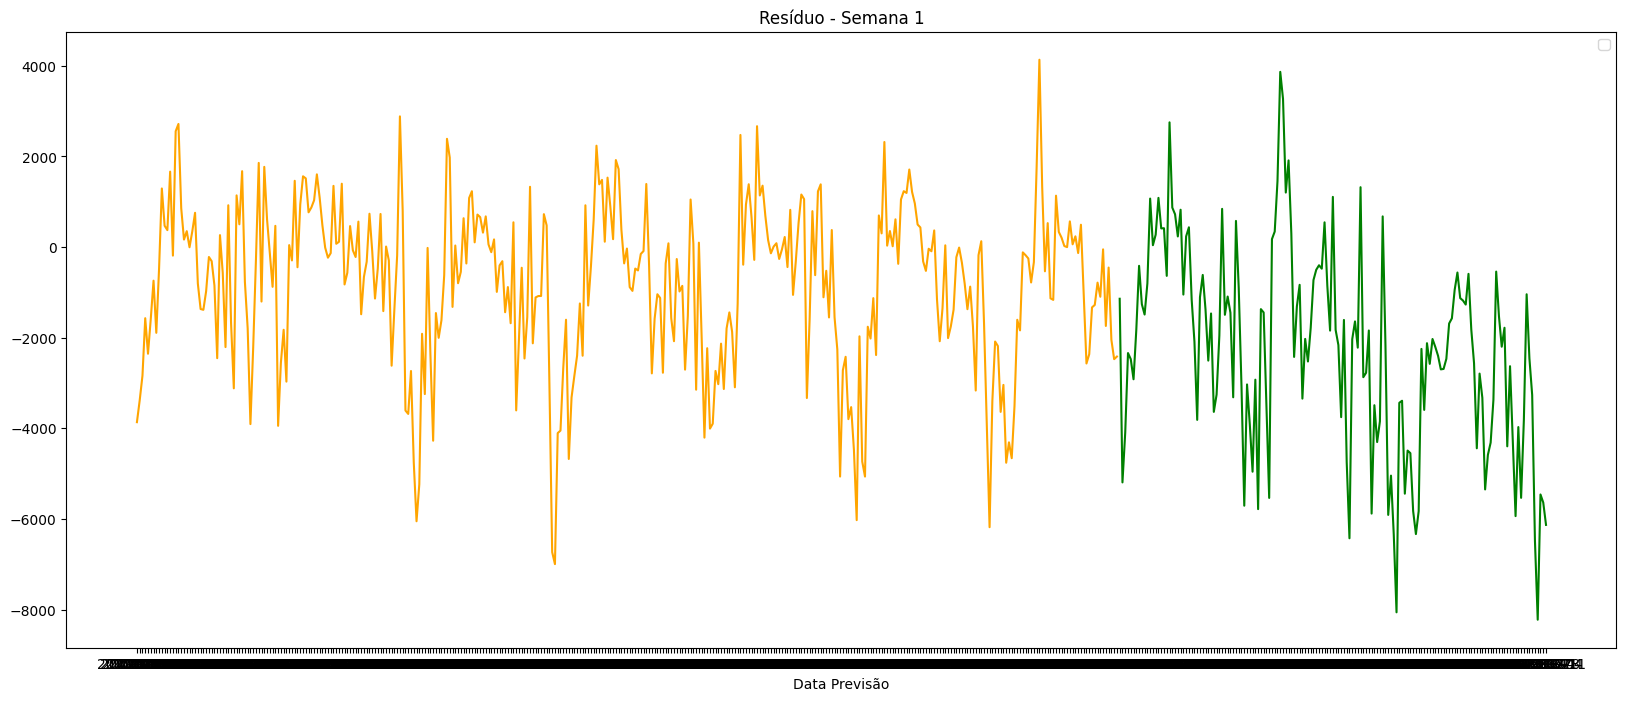

In [8]:
def plot_residual_error(df_target, pred_list, plot=False):
    # variation from one week to the next
    res_baseline = df_target[
        "Resíduo"
    ]  # - df_target['Resíduo'].mean())/df_target['Resíduo'].max()
    # prediction residues
    colors = ["orange", "green", "purple"]

    fig, ax = plt.subplots(figsize=(20, 8))
    # diferença normalizada entre semanas consecutivas
    # sns.lineplot(y=res_baseline, x=df_target['Data'], ax=ax)

    res_list = []
    for pred_set, color in zip(pred_list, colors[: len(pred_list)]):
        pred = pred_set.iloc[:-3]
        res_pred = (
            pred.loc[:, "previsão semana 1"].values - df_target["Semana 1"].loc[pred['Data Previsão']].values
        )
        sns.lineplot(y=res_pred, x=pred['Data Previsão'], ax=ax, color=color)
        res_list.append(res_pred)

    ax.set_title("Resíduo - Semana 1")
    ax.legend("")

    if plot:
        plt.show()
    return fig, res_list


train_semana_metrics = metricas_semana[0].to_dict(orient="dict")
val_semana_metrics = metricas_semana[1].to_dict(orient="dict")
test_semana_metrics = metricas_semana[2].to_dict(orient="dict")

# generates the residual plot
residual_fig, res_list = plot_residual_error(
    df_target,
    pred_list,
)
residual_fig.savefig(os.path.join(VALUATION_PATH, "residuo.png"))
logger.info("RESIDUAL SAVED TO DISK")
